<a href="https://colab.research.google.com/github/kankitakahiro/kikaizemi/blob/main/bandit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 46.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=d21411a7324c79db1eeb7ebcce3aa49c540f741b90353e972e83051f7c653b5e
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


# 平均値を求める実装

1台のスロットマシンに注目して、そのスロットマシンを$n$回プレイする場合を考える。
その時の報酬を、$R_1,R_2,\cdots,R_n$で表し、$n$回行動した時点での行動価値の推定値を$Q_n$で表すと次の式で書ける。(**標本平均**)

$$Q_n = \frac{R_1+R_2+\cdots+R_n}{n}$$

この実装方式の問題点はプレイする回数$(n)$が増えるに従い、rewardsの要素が増える点である。このためプレイする回数が増えるに従い、メモリと計算量が増加していく。

$n-1$回目の時点での行動価値の推定値$Q_{n-1}$を考える。

$$Q_{n-1} = \frac{R_1+R_2+\cdots+R_{n-1}}{n-1}$$

この式の両方に$n-1$をかけると次の式がでる。

$$R_1+R_2+\cdots+R_{n-1} = (n-1)Q_{n-1}$$

これより
\begin{split}
Q_n& = \frac{R_1+R_2+\cdots+R_n}{n}\\
&= \frac{1}{n}(R_1+R_2+\cdots+R_{n-1}+R_n)\\
&= \frac{1}{n}\{(n-1)Q_{n-1} + R_n\}\\
&= (1-\frac{1}{n})Q_{n-1} + \frac{1}{n}R_n\\
&= Q_{n-1} + \frac{1}{n}(R_n - Q_{n-1})
\end{split}

となり、$Q_n$と$Q_{n-1}$の関係式を導くことが出来る。

よって、$Q_n$を求めるには$Q_{n-1}$、$R_n$、$n$の3つの値があれば良いということがわかります。

重要な点は報酬$R_1,R_2,\cdots,R_n$を毎回使わなくても良いという点です。

また、$Q_n$は$Q_{n-1}$を基準にしているということがわかります。

$$Q_{n-1} + \frac{1}{n}(R_n - Q_{n-1})$$

の式から$Q_{n-1}$が$Q_n$に更新される際は$(R_n - Q_{n-1})$を$\frac{1}{n}$倍しただけ更新されるということができる。

ここで$\frac{1}{n}$は更新する量を調整するので「学習率」の役割があることがわかる。



In [2]:
import numpy as np

# naive implementation
np.random.seed(0) # シードを固定
rewards = []

for n in range(1, 11): # 1から10まで
    reward = np.random.rand() #ダミーの報酬
    rewards.append(reward)
    Q = sum(rewards) / n  # 単純な平均値を求める実装
    print(Q)

print('---')

# incremental implementation
np.random.seed(0)
Q = 0

for n in range(1, 11):
    reward = np.random.rand()
    Q = Q + (reward - Q) / n  # Q_{n-1}からQ_nを求める実装
    print(Q)

0.5488135039273248
0.6320014351498722
0.6222554154571295
0.6029123573420713
0.567060845741438
0.5801997236289743
0.5598265075766483
0.6013198192273272
0.6415801460355164
0.6157662833145425
---
0.5488135039273248
0.6320014351498722
0.6222554154571294
0.6029123573420713
0.567060845741438
0.5801997236289743
0.5598265075766483
0.6013198192273272
0.6415801460355164
0.6157662833145425


#バンディットアルゴリズムの実装

## スロットマシンの実装

In [3]:
import numpy as np
import matplotlib.pyplot as plt


class Bandit:
    def __init__(self, arms=10):
      """
      スロットマシンの実装をする。
      Parameters
      ----------
      arms:int
        スロットマシンの台数
      """
      self.rates = np.random.rand(arms)   # 0.0以上1.0未満の乱数が1つ生成される。このとき乱数は一様分布から生成される。
                                          # これによってスロットマシンの勝率がランダムで設定される。
                                          # 一度設定したら変化しない

    def play(self, arm):
      """
      何番目のスロットをプレイするかを指定する。
      Parameters
      ----------
      arm : int
        プレイするスロットの番号

      Returns
      -------
       報酬
      """
      rate = self.rates[arm]
      if rate > np.random.rand():
          return 1
      else:
          return 0


# エージェントの実装

In [4]:
class Agent:
  """
  スロットマシンの価値の推定値やプレイ回数を保持する。

  Attributes
  ----------
  Qs : list
    スロットマシンの価値の推定値
  ns : list
    スロットマシンのプレイ回数
  """
  def __init__(self, epsilon, action_size=10):
    """
    Agentを実装する。
    Parameters
      ----------
      epsilon:int
        ランダムに行動する確率
      action_size:int
        エージェントの選択できる行動の数
    """
    self.epsilon = epsilon
    self.Qs = np.zeros(action_size)
    self.ns = np.zeros(action_size)

  def update(self, action, reward):
    """
    価値を推定する。
    Parameters
      ----------
      action:int
        スロットの番号
      reward:int
        プレイした結果得られた報酬
    """
    self.ns[action] += 1
    self.Qs[action] += (reward - self.Qs[action]) / self.ns[action]

  def get_action(self):
    """
    ε-greedy法によって行動を選択する
    epsilonの確率でランダムな行動を選択する
    Returns
      -------
      np.random.randint(0, len(self.Qs))
          ランダムに選択されたスロット番号
      np.argmax(self.Qs)
          スロットマシンの価値の推定値が最大のスロットマシン
    """
    if np.random.rand() < self.epsilon:
        return np.random.randint(0, len(self.Qs))
    return np.argmax(self.Qs)

# バンディットアルゴリズムを実行する

865


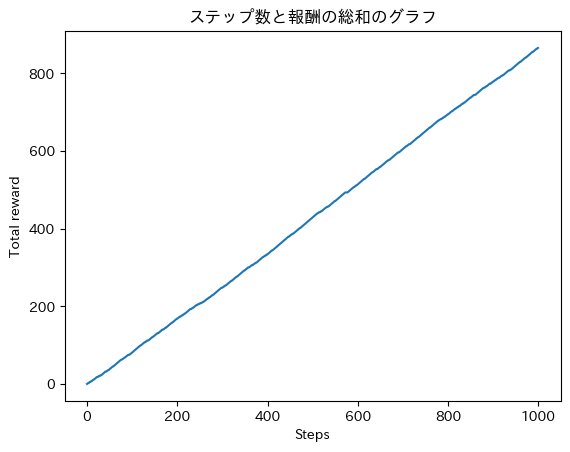

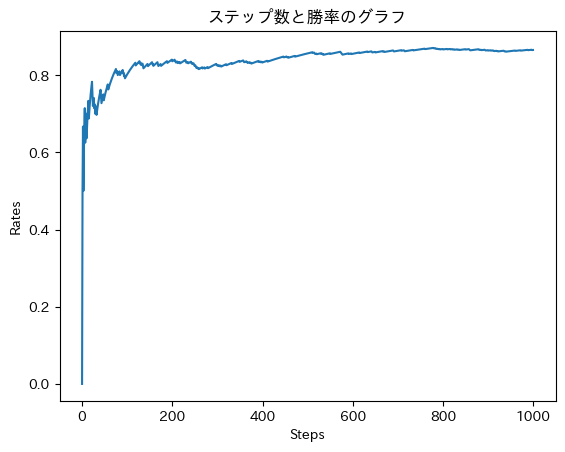

In [5]:
import japanize_matplotlib

"""
ε-greedy法のアルゴリズムの性質を見る

Parameters
  ----------
  steps:int
    プレイ回数
  epsilon:int
    ランダムに行動する確率
  total_reward:int
    報酬の和
  total_rewards:list
    それまでの報酬の和を保持する
  rates:list
    それまでの勝率を保持する
"""

steps = 1000
epsilon = 0.1

bandit = Bandit()
agent = Agent(epsilon)
total_reward = 0
total_rewards = []
rates = []

for step in range(steps):
    action = agent.get_action()
    reward = bandit.play(action)
    agent.update(action, reward)
    total_reward += reward

    total_rewards.append(total_reward)
    rates.append(total_reward / (step + 1))

print(total_reward)
plt.title("ステップ数と報酬の総和のグラフ")
plt.ylabel('Total reward')
plt.xlabel('Steps')
plt.plot(total_rewards)
plt.show()

plt.title("ステップ数と勝率のグラフ")
plt.ylabel('Rates')
plt.xlabel('Steps')
plt.plot(rates)
plt.show()

# 平均的な良さを見る実装

各ステップで平均を求める（all_ratesの中身）

|           ||  1 |  2 | $\cdots$ | 1000 |
|   ----    ||----|----|      ----|----  |
|1回目の実験||1.0 |0.5 |$\cdots$  |0.913 |
|2回目の実験||0.0 |0.0 |$\cdots$  |0.821 |
|$\cdots$||$\cdots$ |$\cdots$ |$\cdots$  |$\cdots$ |
|200回目の実験||1.0 |1.0 |$\cdots$  |0.615 |
|平均||0.493 |0.497 |$\cdots$  |0.838 |





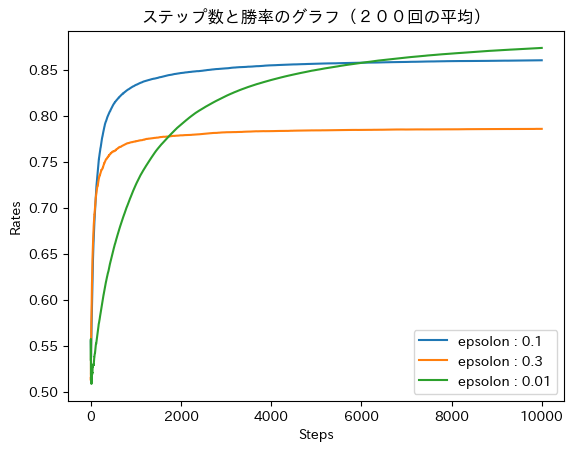

In [6]:
def bandit_avg(epsilon, runs = 200, steps = 10000):
  """
  ε-greedy法のアルゴリズムの性質を見る

  Parameters
  ----------
  runs:int
    実験回数
  steps:int
    プレイ回数
  epsilon:int
    ランダムに行動する確率
  all_rates:list
      各実験で得られた結果を保持する
  """

  all_rates = np.zeros((runs, steps))  # (2000, 1000)の形状の配列

  for run in range(runs):              # 200回の実験
    bandit = Bandit()
    agent = Agent(epsilon)
    total_reward = 0
    rates = []

    for step in range(steps):
        action = agent.get_action()
        reward = bandit.play(action)
        agent.update(action, reward)
        total_reward += reward
        rates.append(total_reward / (step + 1))

    all_rates[run] = rates          # 報酬の結果を記録する

  avg_rates = np.average(all_rates, axis=0)
  return avg_rates
avg_rates_1 = bandit_avg(epsilon=0.1)
avg_rates_2 = bandit_avg(epsilon=0.3)
avg_rates_3 = bandit_avg(epsilon=0.01)
plt.title("ステップ数と勝率のグラフ（２００回の平均）")
plt.ylabel('Rates')
plt.xlabel('Steps')
plt.plot(avg_rates_1,label = "epsolon : 0.1")
plt.plot(avg_rates_2,label = "epsolon : 0.3")
plt.plot(avg_rates_3,label = "epsolon : 0.01")
plt.legend(loc= 'best')

plt.show()

# 非定常問題

今までのbaunditの式（標本平均）

\begin{split}
Q_n& = \frac{R_1+R_2+\cdots+R_n}{n}\\
&= \frac{1}{n}R_1 + \frac{1}{n}R_2 + \cdots + \frac{1}{n}R_n
\end{split}

すべての報酬が同じ重みになっている。

非定常問題では不適切。

なぜなら環境が時間とともに変化するため。

今までのbaunditの式

$$Q_n = Q_{n-1} + \frac{1}{n}(R_n - Q_{n-1})$$

非定常問題の式（指数移動平均）

$\frac{1}{n}$を$\alpha$という**固定値**に変更する$(0<α<1)$

\begin{split}
Q_n& = Q_{n-1} + \alpha(R_n - Q_{n-1})\\
&= \alpha R_n + Q_{n-1} + \alpha Q_{n-1}\\
&= \alpha R_n + (1-\alpha)Q_{n-1}\\
&= \alpha R_n + \alpha(1-\alpha)R_{n-1}+\cdots+\alpha(1-\alpha)^{n-1}R_1 + (1-\alpha)^n Q_0\\
\end{split}


これにより指数関数的に減少するように重みを付けることができる。

この式では$Q_n$を求めるために$Q_0$が使われている。

そのため設定した初期値が影響を与える。

標本平均では初期値は消える。

# スロットマシンの実装

In [10]:
class NonStatBandit:
  def __init__(self, arms=10):
    """
    スロットマシンの実装をする。
    Parameters
    ----------
    arms:int
      スロットマシンの台数
    """
    self.arms = arms
    self.rates = np.random.rand(arms)

  def play(self, arm):
    """
    何番目のスロットをプレイするかを指定する。
    Parameters
    ----------
    arm : int
      プレイするスロットの番号

    Returns
    -------
      報酬
    """
    rate = self.rates[arm]
    self.rates += 0.1 * np.random.randn(self.arms)  # ノイズの追加
    if rate > np.random.rand():
        return 1
    else:
        return 0

# エージェントの実装

In [11]:
class AlphaAgent:
  """
  スロットマシンの価値の推定値を保持する。

  Attributes
  ----------
  Qs : list
    スロットマシンの価値の推定値
  """
  def __init__(self, epsilon, alpha, actions=10):
    """
    Agentを実装する。
    Parameters
      ----------
      epsilon:int
        ランダムに行動する確率
      actions:int
        エージェントの選択できる行動の数
      alpha :
        推定値
    """
    self.epsilon = epsilon
    self.Qs = np.zeros(actions)
    self.alpha = alpha

  def update(self, action, reward):
    """
    価値を推定する。
    Parameters
      ----------
      action:int
        スロットの番号
      reward:int
        プレイした結果得られた報酬
    """
    self.Qs[action] += (reward - self.Qs[action]) * self.alpha # alphaで更新

  def get_action(self):
    """
    ε-greedy法によって行動を選択する
    epsilonの確率でランダムな行動を選択する
    Returns
      -------
      np.random.randint(0, len(self.Qs))
          ランダムに選択されたスロット番号
      np.argmax(self.Qs)
          スロットマシンの価値の推定値が最大のスロットマシン
    """
    if np.random.rand() < self.epsilon:
        return np.random.randint(0, len(self.Qs))
    return np.argmax(self.Qs)

# 実行する

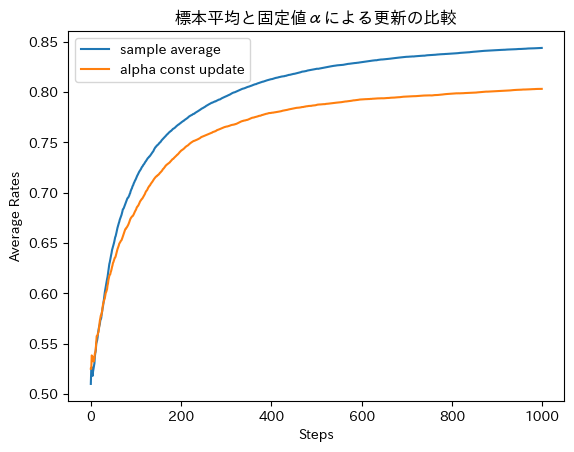

In [12]:
runs = 200
steps = 1000
epsilon = 0.1
alpha = 0.8
agent_types = ['sample average', 'alpha const update']
results = {}

for agent_type in agent_types:
    all_rates = np.zeros((runs, steps))  # (200, 1000)

    for run in range(runs):
        if agent_type == 'sample average':
            agent = Agent(epsilon)
        else:
            agent = AlphaAgent(epsilon, alpha)

        bandit = NonStatBandit()
        total_reward = 0
        rates = []

        for step in range(steps):
            action = agent.get_action()
            reward = bandit.play(action)
            agent.update(action, reward)
            total_reward += reward
            rates.append(total_reward / (step + 1))

        all_rates[run] = rates

    avg_rates = np.average(all_rates, axis=0)
    results[agent_type] = avg_rates

# plot
plt.figure()
plt.title("標本平均と固定値αによる更新の比較")
plt.ylabel('Average Rates')
plt.xlabel('Steps')
for key, avg_rates in results.items():
    plt.plot(avg_rates, label=key)
plt.legend()
plt.show()